## 0. Imports

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam
from tqdm.notebook import tqdm

from scipy.stats import norm

In [2]:
seed = 0
pl.seed_everything(seed=seed);

Global seed set to 0


## 1. Model and Data Modules

In [3]:
class ConvexNN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, output_dim=1, max_out=4, bias=False):
        super().__init__()
        max_out_adusted_hidden_dim = hidden_dim // max_out
        self.input_to_hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=bias),
            nn.MaxPool1d(kernel_size=max_out)
        )
        self.main = nn.Sequential(
            nn.Linear(max_out_adusted_hidden_dim, hidden_dim, bias=bias),
            nn.MaxPool1d(kernel_size=max_out),
            nn.Linear(max_out_adusted_hidden_dim, output_dim, bias=bias)
        )
        self.project_params_for_cvxty()
    
    def forward(self, x):
        hidden = self.input_to_hidden(x)
        return self.main(hidden)
    
    def project_params_for_cvxty(self):
        for module in self.main.modules():
            if module and hasattr(module, 'weight'):
                with torch.no_grad():
                    module.weight.data.relu_()
                    
    def test_convexity(self, batch_size=64, eps=1e-6):
        x = torch.randn((batch_size, 1))
        with torch.no_grad(): 
            # Sample lambda uniformly
            lmbds = torch.rand((batch_size, 1))

            # Shuffle indices to randomly select images
            indices1 = torch.randperm(x.shape[0])
            indices2 = torch.randperm(x.shape[0])

            # Check that `f(lambda x + (1-lambda)y) <= lambda f(x) + (1-lambda) f(y)`
            convex_combo_of_inputs = self(lmbds * x[indices1] + (1 - lmbds) * x[indices2])
            convex_combo_of_outputs = lmbds * self(x[indices1]) + (1 - lmbds) * self(x[indices2])
            return torch.sum(convex_combo_of_inputs <= convex_combo_of_outputs + eps).item() / batch_size
        
    def get_weight_norms(self):
        param_norm = 0
        numel = 0
        for name, module in self.named_modules():
            param_norm = 0
            numel = 0
            if name == '':
                continue
            for param in module.parameters():
                if param.requires_grad:
                    with torch.no_grad():
                        param_norm += param.norm(2).detach().item() ** 2
                        numel += param.numel()
        return math.sqrt(param_norm) / numel

In [4]:
class MultiModalGaussian1D:
    def __init__(self, n_modes=3, mu_scale=1, sigma_scale=1, mus=None, sigmas=None):
        super(MultiModalGaussian1D).__init__()
        self.n_modes = n_modes
        self.mus = mus if mus is not None else (-2*torch.rand(n_modes) + 1)*mu_scale
        self.sigmas = sigmas if sigmas is not None else torch.rand(n_modes)*sigma_scale
        self.dists = [Normal(m, s) for m, s in zip(self.mus, self.sigmas)]

    def sample(self, batch_size):
        return torch.concat([d.sample((batch_size // self.n_modes, 1)) for d in self.dists], dim=0)

## 2. Optimization Loop

In [5]:
def sample(batch_size, dists):
    return [d.sample(batch_size) for d in dists]

def optimization_loop(u, u_opt, dists, iterations, batch_size):    
    pbar = tqdm(range(iterations), desc='Iter')
    vdc_log = []
    steps = 0
    u.train()
    for i in pbar:
        # Sample pts
        samples = sample(batch_size, dists)
        
        # Calculate objectives
        critic_on_dominating = u(samples[0]).mean()
        critic_on_dominated = u(samples[1]).mean()
        vdc = critic_on_dominating - critic_on_dominated
        vdc_log.append(vdc.item())
        
        # Take gradient steps: alternate training z and u
        u_opt.zero_grad()
        vdc.backward()
        u_opt.step()
        u.project_params_for_cvxty()
        steps += 1
        
        # Test u convexity
        cvxty = u.test_convexity(batch_size=batch_size)
        
        # Log values to pbar
        with torch.no_grad():
            postfix_str = f'u(μ+): {critic_on_dominating.item():0.2f}, ' + \
                          f'u(μ-): {critic_on_dominated.item():0.2f}, ' + \
                          f'VDC: {vdc.item():0.2f}, ' + \
                          f'cvx: {cvxty:0.2f}'
            pbar.set_postfix_str(postfix_str)
    return {'vdc': vdc.item(), 'vdc_log': vdc_log}

## 3. Run optimization

In [6]:
# Hyperparams
u_hidden_dim = 32
u_max_out = 4
u_bias = True
bsz = 1024
iters = 5000
u_lr = 5e-5

In [7]:
# Models and optimizer
u = ConvexNN(hidden_dim=u_hidden_dim, max_out=u_max_out, bias=u_bias)
u_opt = Adam(params=u.parameters(), lr=u_lr, maximize=False)

# Data
mu3 = torch.FloatTensor([-10, 0, 10])
sigma3 = torch.FloatTensor([2, 2, 2])
m3 = MultiModalGaussian1D(n_modes=3, mus=mu3, sigmas=sigma3)

mu2 = torch.FloatTensor([-10, 10])
sigma2 = torch.FloatTensor([2, 2])
m2 = MultiModalGaussian1D(n_modes=2, mus=mu2, sigmas=sigma2)


mu1 = torch.zeros(1)
sigma1 = torch.ones(1)*3
m1 = MultiModalGaussian1D(n_modes=1, mus=mu1, sigmas=sigma1)
dists = [m3, m1]

In [8]:
# Run loop
opt_output = optimization_loop(u=u, u_opt=u_opt, dists=dists, iterations=iters, batch_size=bsz);

Iter:   0%|          | 0/5000 [00:00<?, ?it/s]

## 4. Plots

In [9]:
def mix_norm_cdf(x, dist):
    mcdf = 0.0
    for i in range(dist.mus.shape[0]):
        mcdf += 1/dist.mus.shape[0] * norm.cdf(x, loc=dist.mus[i].item(), scale=dist.sigmas[i].item())
    return mcdf

def mix_norm_pdf(x, dist):
    mpdf = 0.0
    for i in range(dist.mus.shape[0]):
        mpdf += 1/dist.mus.shape[0] * norm.pdf(x, loc=dist.mus[i].item(), scale=dist.sigmas[i].item())
    return mpdf

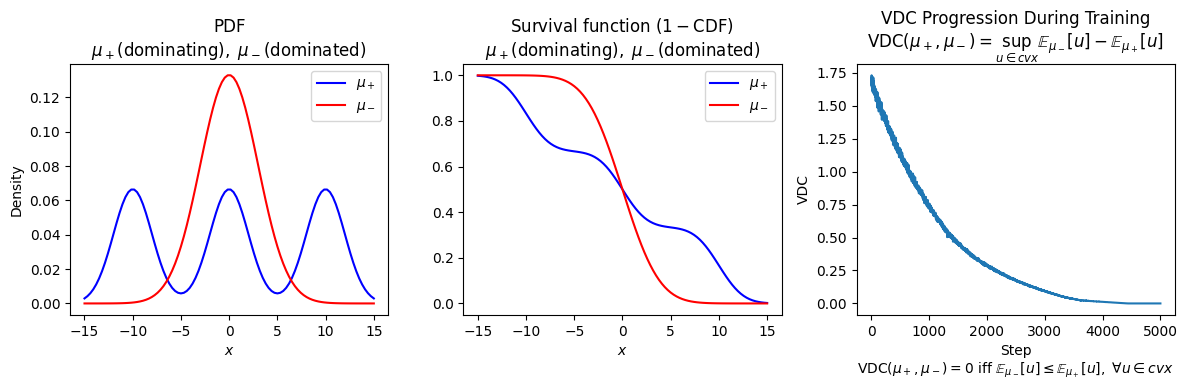

In [10]:
pts = np.linspace(-15, 15, 100)
fig, ax = plt.subplots(1, 3, figsize=(12,4), tight_layout=True)

# PDF:
pdf_values_μ_plus = np.array([mix_norm_pdf(c, dists[0]) for c in pts])
pdf_values_μ_minus = np.array([mix_norm_pdf(c, dists[1]) for c in pts])
ax[0].plot(pts, pdf_values_μ_plus, color='blue', label=r'$\mu_+$')
ax[0].plot(pts, pdf_values_μ_minus, color='red', label=r'$\mu_-$')
ax[0].set_title('PDF' + '\n' + r'$\mu_+ \mathrm{(dominating)}, ~ \mu_- \mathrm{(dominated)}$')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Density')
ax[0].legend()


# Survival fxn:
cdf_values_μ_plus = np.array([mix_norm_cdf(c, dists[0]) for c in pts])
cdf_values_μ_minus = np.array([mix_norm_cdf(c, dists[1]) for c in pts])
ax[1].plot(pts, 1-cdf_values_μ_plus, color='blue', label='$\mu_+$')
ax[1].plot(pts, 1-cdf_values_μ_minus, color='red', label='$\mu_-$')
ax[1].set_title('Survival function ' + '$(1 - \mathrm{CDF})$' + '\n' + \
                '$\mu_+ \mathrm{(dominating)}, ~ \mu_- \mathrm{(dominated)}$')
ax[1].set_xlabel('$x$')
ax[1].legend()

# VDC
ax[2].plot(range(len(opt_output['vdc_log'])), opt_output['vdc_log'])
ax[2].set_title('VDC Progression During Training\n' + \
                '$\mathrm{VDC}(\mu_+, \mu_-) = \sup_{u \in cvx}\mathbb{E}_{\mu_-}[u] - \mathbb{E}_{\mu_+}[u]$')
ax[2].set_xlabel('Step' + '\n' + \
                 '$\mathrm{VDC}(\mu_+, \mu_-) = 0$' + \
                 r'$\mathrm{~iff~} \mathbb{E}_{\mu_-}[u] \leq \mathbb{E}_{\mu_+}[u], ~ \forall u \in cvx$')
ax[2].set_ylabel('VDC')
plt.show()

In [11]:
# # Uncomment below to generate separate plots

# # PDF:
# plt.plot(pts, pdf_values_μ_plus, color='blue', label=r'$\mu_+$')
# plt.plot(pts, pdf_values_μ_minus, color='red', label=r'$\mu_-$')
# plt.title('PDF' + '\n' + r'$\mu_+ \mathrm{(dominating)}, ~ \mu_- \mathrm{(dominated)}$')
# plt.xlabel(r'$x$')
# plt.ylabel('Density')
# plt.legend()
# plt.show()

# # Survival fxn:
# cdf_values_μ_plus = np.array([mix_norm_cdf(c, dists[0]) for c in pts])
# cdf_values_μ_minus = np.array([mix_norm_cdf(c, dists[1]) for c in pts])
# plt.plot(pts, 1-cdf_values_μ_plus, color='blue', label='$\mu_+$')
# plt.plot(pts, 1-cdf_values_μ_minus, color='red', label='$\mu_-$')
# plt.title('Survival function ' + '$(1 - \mathrm{CDF})$' + '\n' + \
#                 '$\mu_+ \mathrm{(dominating)}, ~ \mu_- \mathrm{(dominated)}$')
# plt.xlabel('$x$')
# plt.legend()
# plt.show()

# # VDC
# plt.plot(range(len(opt_output['vdc_log'])), opt_output['vdc_log'])
# plt.title('VDC Progression During Training\n' + \
#                 '$\mathrm{VDC}(\mu_+, \mu_-) = \sup_{u \in cvx}\mathbb{E}_{\mu_-}[u] - \mathbb{E}_{\mu_+}[u]$')
# plt.xlabel('Step' + '\n' + \
#                  '$\mathrm{VDC}(\mu_+, \mu_-) = 0$' + \
#                  r'$\mathrm{~iff~} \mathbb{E}_{\mu_-}[u] \leq \mathbb{E}_{\mu_+}[u], ~ \forall u \in cvx$')
# plt.ylabel('VDC')
# plt.show()